# 분류 (Classification)
- 회귀와 더불어 지도 학습의 대표적인 예시 
  - 회귀 : 값 예측   
  - 분류 : 클래스 예측

# 0. 목표 
> 손글씨 숫자를 보고 어떤 숫자인지 분류

# 1. MNIST 데이터셋 
> 학습용으로 자주 쓰이는 데이터 셋 중 하나 

## 1) sklearn.dataset 특징 
### 데이터셋 다운로드 함수 
  - `fetch_*` : 실전 데이터셋을 다운로드 하는 함수 
 -  `fetch_openml()` : 입력을 판다스 데이터 프레임 / 레이블을 판다스 시리즈로 반환
  - `load_*` :  소규모 데이터셋 로드 (인터넷 다운로드 불필요)
  - `make_*` : 가짜 데이터셋 생성 


### 데이터셋 객체 특성
- 일반적으로 넘파이 배열로 생성
- (`입력값`,`타깃`)의 튜플 반환 
- `sklearn.utils.Bunch`객체로 반환되는 경우도 있음 

#### 객체 속성 
- `DESCR` : 데이터셋 설명 
- `data` : 입력 데이터 - 2D 넘파이 배열
- `target` : 레이블 - 1D 넘파이 배열



## 2) MNIST 데이터 로드 

- fetch_openml을 이용해서 데이터를 불러옴 
    -  단, MNIST는 이미지 데이터라서 데이터 프레임과 어울리지 않음 
    -  `as_frame=False`로 지정하여 넘파이 배열로 데이터를 받음

In [4]:
from sklearn.datasets import fetch_openml 

### 손글씨 데이터를 넘파이 배열로 로드 
mnist = fetch_openml("mnist_784", as_frame=False)

### X : 이미지 데이터, y : 레이블
X, y = mnist.data, mnist.target

### X데이터 확인
print(X)
print("X shape:", X.shape)

### y데이터 확인
print(y)
print("y shape:", y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
X shape: (70000, 784)
['5' '0' '4' ... '4' '5' '6']
y shape: (70000,)


### 데이터의 특성 
- 이미지 : 70,000개의 손글씨 숫자 이미지
- 각 이미지 : 28x28 픽셀, 총 784개의 픽셀
- 특성은 0~255 사이의 값 -> 픽셀의 강도
-> 이를 이용해 이미지로 표현 가능 `matplotlib의 imshow()`

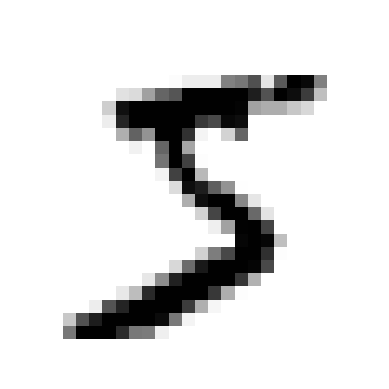

레이블: 5


In [22]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

### 이미지를 그려내는 함수 
def plot_digit(image_data):
    ### 784 픽셀 데이터를 28x28 이미지로 변환
    image = image_data.reshape(28, 28) 
   
    ### 이미지를 그리기
    ### binary 컬러맵을 사용하여 흑백 이미지로 표시
    plt.imshow(image, cmap="binary")
   
   # 축을 표시하지 않음
    plt.axis("off") 

# 첫 번째 이미지 데이터 선택
some_digit = X[0]  

# 선택한 이미지 데이터 출력
plot_digit(some_digit)
plt.show()

# 레이블 출력
print("레이블:", y[0])  

## 3) 테스트 데이터 분할 
- `fetch_openml` 데이터는 훈련세트와 테스트 세트가 이미 나눠져있음 
    - 훈련 세트 : 앞의 60,000개 샘플
    - 테스트 세트 : 뒤의 10,000개 샘플
  - 훈련 세트는 이미 섞여 있음 > 검증 폴드를 비슷하게 만듦

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 2. 이진 분류기 훈련 
- `이진 분류기` : True 인지 False 인지 분류하는 분류기 

## 확률적 경사하강법 (SGD) 분류기 
- SGD 장점 : 큰 데이터셋을 효율적으로 처리 
-하나씩 훈련 샘플을 독립적 처리 가능 -> 온라인 학습에 적합 
- 사이킷 런에서 `SGDClassifier` 클래스 제공

### 타깃 벡터 생성 
- 5면 True, 아니면 False인 벡터 생성 

In [8]:
y_train_5 = (y_train == "5") 
y_test_5 = (y_test == "5")

### SGDClassifier 분류기 생성/예측

In [9]:
from sklearn.linear_model import SGDClassifier

### SGD 객체 생성
sgd_clf = SGDClassifier(random_state=42)

### 모델 학습 - 5를 예측하는 이진 분류기
### 타겟 :  5이면 True, 아니면 False
sgd_clf.fit(X_train, y_train_5)

### 모델 예측
sgd_clf.predict([some_digit]) 

array([ True])

# 3. 모델 성능 측정 

## 1) 교차 검증을 이용한 정확도
- `cross_val_score`를 사용하여 교차 검증을 수행
- `정확도` : 정확히 예측한 비율 

### 예시 )  k=3인 k-폴드 교차검증 평가 
 - K 폴드 교차 검증 이후 , 더미 분류기와 성능 비교 
 - `더미 분류기` : 5가 아닌 데이터로 학습한 분류기 

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

### 교차 검증을 통한 정확도 측정 
print(f"교차검증을 이용한 정확도 : {cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")}") 

### 더미 분류기와의 비교 
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(f"더미 분류기의 정확도 : {cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')}") 

교차검증을 이용한 정확도 : [0.95035 0.96035 0.9604 ]
더미 분류기의 정확도 : [0.90965 0.90965 0.90965]


### 정확도의 단점 
- 불균형한 데이터 셋을 다룰 때, 정확도만으로는 모델의 성능을 평가하기 어려움

- 5가 아닌 데이터 90%, 5인 데이터 10%로 구성된 데이터셋에서
  - 더미 분류기는 90%의 정확도를 달성
- 더미 분류기 정확도 : 90% 이상
- SGD 분류기 정확도 : 95% 이상


## 2) 오차 행렬 
- 잘못 분류된 횟수를 세는 것 

### 오차행렬을 만드는 방법 
- 실제 타겟과 예측값을 만듦 -> `cross_val_predict()`

#### cross_val_predict()
- k폴드 교차 검증을 수행하지 않음 -> 평가 점수를 반환하지 않음 
- 깨끗한 예측값을 반환함

#### confusion_matrix()
- 실제 타겟과 예측값을 비교하여 오차 행렬을 만듦

- 예시 : 5 예측 오차 행렬

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

### 교차 검증을 통한 예측 - 예측값만 출력
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

### 오차 행렬 생성 
cm = confusion_matrix(y_train_5, y_train_pred)
print("오차 행렬:\n", cm)

오차 행렬:
 [[53892   687]
 [ 1891  3530]]


### 1종오류와 2종오류 
#### 1종 오류 (1,2)
- 거짓 양성 (False Positive, FP) : 실제로는 5가 아닌데 5라고 잘못 예측한 경우
#### 2종 오류 (2,1)
- 거짓 음성 (False Negative, FN) : 실제로는 5인데 5가 아니라고 잘못 예측한 경우

## 3) 정밀도와 재현율

### 정밀도 
- `정밀도` : 양성으로 예측한 것 중 실제 양성인 비율
- $\text{정밀도} = \frac{TP}{TP+FP}$
- 사이킷 런에서 `precision_score` 제공

### 재현률 
- `재현률` : 분류기가 정확하게 감지한 양성 샘플의 비율 -> 민감도 혹은 진짜 양성 비율(TPR)
 - $\text{재현율} = \frac{TP}{TP+FN}$
 - 사이킷 런에서 `recall_score` 제공 

### $F_1$ 점수 
- 정밀도와 재현율을 이용한 조화 평균 점수 
- 사이킷 런에서 `f1_score()` 함수 제공
- 정밀도와 재현율의 비율이 비슷할 때 점수가 높음
  - 항상 바람직 한 것은 아님 

In [16]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

### 정밀도 계산 
precision = precision_score(y_train_5, y_train_pred)
print("정밀도:", precision)

### 재현율 계산
recall = recall_score(y_train_5, y_train_pred)
print("재현율:", recall)

### F1 점수 계산
f1 = f1_score(y_train_5, y_train_pred)
print("F1 점수:", f1)

정밀도: 0.8370879772350012
재현율: 0.6511713705958311
F1 점수: 0.7325171197343847


## 4) 정밀도 - 재현율 트레이드오프
- 정밀도가 올라가면 재현율이 줄고, 재현율이 올라가면 정밀도가 줄어드는 트레이드오프 관계

### 결정 임계값 
- 결정 임계값을 조정하여 정밀도와 재현율의 균형을 맞출 수 있음
- 임계값 높아짐 : 정밀도 상승, 재현율 하락
- 임계값 낮아짐 : 재현율 상승, 정밀도 하락

### 사이킷 런에서 구현 
- 직접 임계값을 지정 불가 
- `decision_function` 메서드를 사용 > 샘플 점수를 얻음 > 임곗값을 정해 예측 

- 임계값이 0 > predict() 값과 동일한 결과 
- 임계값이 300000 > 재현률이 줄어듦 

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
print("결정 함수 값:", y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("예측 결과 (임계값 0):", y_some_digit_pred)

threshold = 300000
y_some_digit_pred = (y_scores > threshold)
print("예측 결과 (임계값 300000):", y_some_digit_pred)

결정 함수 값: [2164.22030239]
예측 결과 (임계값 0): [ True]
예측 결과 (임계값 300000): [False]


### 적절한 임계값 구하는 방법 
1. `cross_val_predict()` 함수를 이용해 모든 샘플의 점수를 구함 
2. `precision_recall_curve()` 함수를 이용해 임계값에 대한 정밀도-재현율 계산

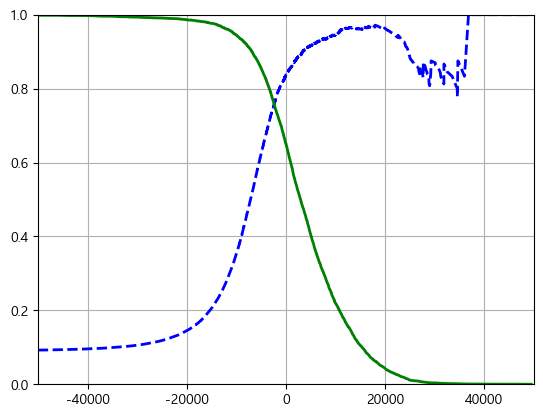

In [26]:
from sklearn.metrics import precision_recall_curve

### 모든 샘플의 결정 점수 반환 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

### 정밀도-재현율 곡선 계산
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### 임계값이 3000일 때의 그래프 생성 

### 정밀도 : 파란색 점선 
plt.plot(thresholds, precisions[:-1], "b--", label="정밀도",linewidth=2)

### 재현율 : 초록색 실선
plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)

plt.vlines(threshold, 0 , 1.0, "k","dotted", label="임계값")

### x축  범위 
plt.axis([-50000, 50000, 0, 1])
plt.grid()

plt.show()

3. 재현율에 대한 정밀도 곡선 그리기 - > 정밀도 / 재현율 곡선 
- 재현율 80% 근처에서 정밀도가 급격히 줄어듦 
- 하강점 직전을 트레이드 오프로 설정하는 것이 좋음 

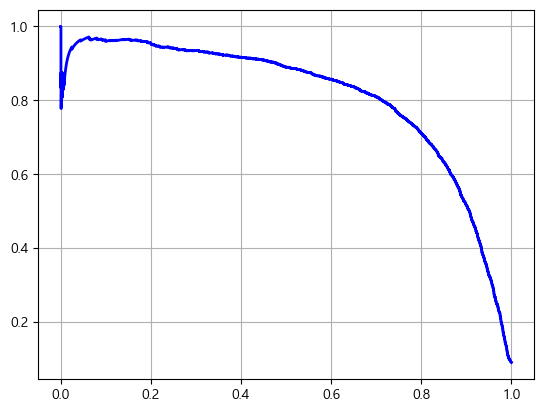

In [28]:
plt.plot(recalls, precisions, "b-", linewidth=2, label="정밀도-재현율 곡선")
plt.grid()
plt.show()

### 예시 ) 정밀도 90% 목표 
- 달성방법 1 : 그래프에서 임계값 선택 -> 정확한 숫지를 알 수 없음 
- 달성방법 2 : 정밀도가 최소 90%가 되는 가장 낮은 임계값을 선택 
  - 넘파이의 `argmax()` 매서드 활용 

In [34]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_90_precision = thresholds[idx_for_90_precision]
print("90% 정밀도에 해당하는 임계값:", threshold_90_precision)

90% 정밀도에 해당하는 임계값: 3370.0194991439557


- 예측 생성 
- 예측에 대한 정밀도와 재현율을 계산

In [35]:
### 예측값 생성 
y_train_pred_90 = (y_scores >= threshold_90_precision)
print("90% 정밀도로 예측한 결과:", y_train_pred_90)

### 정밀도 
print("90% 정밀도로 예측한 결과의 정밀도:", precision_score(y_train_5, y_train_pred_90))

### 재현율 
print("90% 정밀도로 예측한 결과의 재현율:", recall_score(y_train_5, y_train_pred_90))

90% 정밀도로 예측한 결과: [False False False ...  True False False]
90% 정밀도로 예측한 결과의 정밀도: 0.9000345901072293
90% 정밀도로 예측한 결과의 재현율: 0.4799852425751706
